<div align="center">

---
# NVIDIA Stock Price Forecasting
---
</div>

This Project mainly focuses on trying to predict the **NVIDIA Stock's Market Price** using data from the yahoo Finance market history alongside with **Long Short-Term Memory Models** (LSTM's).

The prediction methodology is based on **Univariate Forecasting**, which means that we are only to consider ``n`` previous values to predict the subsequent/next one.

In [1]:
%load_ext autoreload
%autoreload 2

# Importing Dependencies
import numpy as np
import pandas as pd

# Import json to help save dictionaries into .json files
import json

# Import matplotlib to help visualize the data
import matplotlib.pyplot as plt

# Import Datetime to properly format the Dates from the Dataset
from datetime import (datetime, timedelta)

# Importing an API to handle the Datset from Yahoo Finance
import yfinance as yf

# Import a Sequential Model from tensorflow alongside the Adam Optimizer and layers
from tensorflow.keras.models import (Sequential)
from tensorflow.keras.optimizers import (Adam)
from tensorflow.keras import (layers)

# Import developed functions to help preprocess and visualize the data
from CustomUtilities.Configuration import (load_config)
from CustomUtilities.DataPreProcessing import (str_to_datetime, df_to_windowed_df, windowed_df_to_date_X_y)
from CustomUtilities.DataVisualization import (plot_model_performance, plot_model_overall_performance)

---
## Available Stocks
---

The user is free to change the **stock being studied**. Therefore, let's check which ones are covered by the **yfinance module** even though that this project focuses on the **NVDIA Stock**.

In [2]:
# Load the Dataset and display a few stocks
stocks_df = pd.read_csv("./Available_Stocks.csv", index_col=["Symbol"], usecols=["Symbol", "Name", "Last Sale", "Country", "Volume", "Sector", "Industry"])
stocks_df.head(10)

,Name,Last Sale,Country,Volume,Sector,Industry
Symbol,,,,,,
A,Agilent Technologies Inc. Common Stock,$136.94,United States,411298,Industrials,Biotechnology: Laboratory Analytical Instruments
AA,Alcoa Corporation Common Stock,$31.17,United States,2389048,Industrials,Aluminum
AACG,ATA Creativity Global American Depositary Shares,$0.613,China,3343,Real Estate,Other Consumer Services
AACI,Armada Acquisition Corp. I Common Stock,$10.80,United States,23380,Finance,Blank Checks
AACIU,Armada Acquisition Corp. I Unit,$11.95,United States,13630,Finance,Blank Checks
AACIW,Armada Acquisition Corp. I Warrant,$0.139,United States,107742,Finance,Blank Checks
AACT,Ares Acquisition Corporation II Class A Ordina...,$10.755,NaN,75691,Finance,Blank Checks
AADI,Aadi Bioscience Inc. Common Stock,$1.37,United States,37948,Health Care,Biotechnology: Pharmaceutical Preparations
AAGR,African Agriculture Holdings Inc. Common Stock,$0.128,United States,194849,Consumer Staples,Farming/Seeds/Milling


In [3]:
# Create a dictionary with the stocks names and the corresponding symbols
stocks_dict = pd.Series(stocks_df.Name, index=stocks_df.index).to_dict()

In [4]:
# Save the stocks into a .json file to later visualize the data on a proper editor
json.dump(stocks_dict, open("./Available_Stocks.json", 'w'))

---
## Dataset Extraction
---

In this Section we **extract the market's history data of the NVIDIA Stock** to further use in the LSTM's.

In [5]:
# dataset @ https://finance.yahoo.com/quote/NVDA/history/

In [6]:
# Load the config
config = load_config()

In [7]:
# Getting the Stock Market Information
stock_information = yf.Ticker(config['stock'])

# Fetching a dataset with the stock's history data
if config['max_period']:
    stock_history = stock_information.history(period="max")
else:
    stock_history = stock_information.history(start=config['start_date'], end=config['end_date'])

# Saving the History data into a csv file
stock_history.to_csv(f"./{config['stock']}.csv")

In [8]:
# Defining a N degree for the Model - Choosing the amount of previous values to consider for a certain instant
N = 3 if config['N'] is None else config['N']

---
## Dataset PreProcessing
---

In [9]:
# Loading the Dataset
df = pd.read_csv(f"./{config['stock']}.csv")

In [10]:
# Getting the Number of Rows and Columns of the Dataset
n_rows, n_cols = df.shape
print(f"The dataset contains {n_rows} rows and {n_cols} columns")

The dataset contains 422 rows and 8 columns


In [11]:
# Getting Initial / Oldest 5 Records
df.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2022-12-05 00:00:00-05:00,16.669455,16.985274,16.462573,16.600494,352255000,0.0,0.0
1,2022-12-06 00:00:00-05:00,16.520537,16.563512,15.809944,15.977848,352694000,0.0,0.0
2,2022-12-07 00:00:00-05:00,15.762972,16.176735,15.658031,16.110773,372388000,0.0,0.0
3,2022-12-08 00:00:00-05:00,16.263687,17.169168,15.949866,17.159174,515456000,0.0,0.0
4,2022-12-09 00:00:00-05:00,17.150178,17.572936,16.965284,16.991268,465338000,0.0,0.0


In [12]:
# Getting Final / Most Recent 5 Records
df.tail(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
417,2024-08-05 00:00:00-04:00,92.059998,103.410004,90.690002,100.449997,552842400,0.0,0.0
418,2024-08-06 00:00:00-04:00,103.839996,107.709999,100.550003,104.250000,409012100,0.0,0.0
419,2024-08-07 00:00:00-04:00,107.809998,108.800003,98.690002,98.910004,411440400,0.0,0.0
420,2024-08-08 00:00:00-04:00,102.000000,105.500000,97.519997,104.970001,391910000,0.0,0.0
421,2024-08-09 00:00:00-04:00,105.639999,106.599998,103.430000,104.750000,290844200,0.0,0.0


In [13]:
# Formatting the Datetime in order to only keep the date
df['Date'] = df['Date'].apply(lambda x: x.split(' ')[0])
df[['Date']].head(3)

,Date
0,2022-12-05
1,2022-12-06
2,2022-12-07


In [14]:
# Selecting Important Columns
df = df[['Date', 'Close']]
df.head(3)

,Date,Close
0,2022-12-05,16.600494
1,2022-12-06,15.977848
2,2022-12-07,16.110773


In [15]:
# Getting a date string from the dataset [In this case it is the first one]
first_date_dataset = df['Date'][0]

# Testing the previous function on the extracted date
str_to_datetime(first_date_dataset)

datetime.datetime(2022, 12, 5, 0, 0)

In [16]:
# Now, let's update the dataframe in order for the dates to be formated accordingly with this most recent approach
df['Date'] = df['Date'].map(lambda date_string : str_to_datetime(date_string))

# Inspect the result
df['Date']

0     2022-12-05
1     2022-12-06
2     2022-12-07
3     2022-12-08
4     2022-12-09
         ...    
417   2024-08-05
418   2024-08-06
419   2024-08-07
420   2024-08-08
421   2024-08-09
Name: Date, Length: 422, dtype: datetime64[ns]

In [17]:
# Saving the Earliest and Latest Dates to be considered
earliest_date = str(df['Date'][N].date())
latest_date = str(df['Date'][len(df) - 1].date())

In [18]:
# Set the Date column as the index column
df.set_index('Date', inplace=True)

# Inspect the dataframe
df.head(3)

,Close
Date,
2022-12-05,16.600494
2022-12-06,15.977848
2022-12-07,16.110773


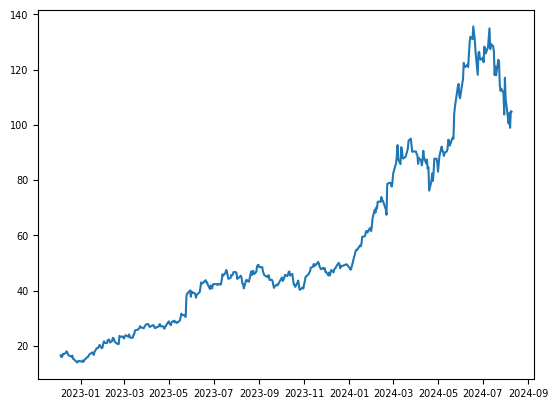

In [19]:
# Plotting the Closing Values of the Stock throughout the years
plt.rc('font', size=7);
plt.plot(df.index, df['Close'])

In [20]:
# Extracting the previous N values of each possible instant along with the target value
windowed_df = df_to_windowed_df(df, 
                                earliest_date, 
                                latest_date, 
                                n=N)
windowed_df.head(5)

,Target_Date,Target-3,Target-2,Target-1,Target
0,2022-12-08,16.600494,15.977848,16.110773,17.159174
1,2022-12-09,15.977848,16.110773,17.159174,16.991268
2,2022-12-12,16.110773,17.159174,16.991268,17.524961
3,2022-12-13,17.159174,16.991268,17.524961,18.061657
4,2022-12-14,16.991268,17.524961,18.061657,17.663881


In [21]:
# Get the Dates as well as the input and output vectors
dates, X, y = windowed_df_to_date_X_y(windowed_df)

# Verifying the shape of each vector
print(f"{dates.shape=} {X.shape=} {y.shape=}")
assert dates.shape[0] == X.shape[0] and dates.shape[0] == y.shape[0], "Vectors shape not Matching!"

dates.shape=(419,) X.shape=(419, 3, 1) y.shape=(419,)


---
## Data Partitioning (Train - Validation - Test)
---

Now it's time to partition the **clean data** into proper **feature and target vectors (X and y)**.

In [22]:
# Getting the threshold values for train and validation (To which values should we consider as train/validation sets)
train_threshold = int(len(dates) * .8)
validation_threshold = int(len(dates) * .9)

# Get the Train data
dates_train = dates[:train_threshold]
X_train = X[:train_threshold]
y_train = y[:train_threshold]

# Get the Validation data
dates_validation = dates[train_threshold : validation_threshold]
X_validation = X[train_threshold : validation_threshold]
y_validation = y[train_threshold : validation_threshold]

# Get the Test data
dates_test = dates[validation_threshold:]
X_test = X[validation_threshold:]
y_test = y[validation_threshold:]

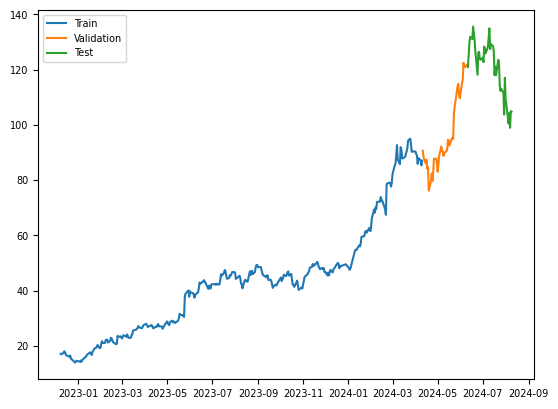

In [23]:
# Plot the Partitioning of the Data (Inspect which values are being used in each set)
plt.plot(dates_train, y_train)
plt.plot(dates_validation, y_validation)
plt.plot(dates_test, y_test)
plt.legend(['Train', 'Validation', 'Test']);

---
## Model Development
---

After inspecting the **data partitioning**, we are left to **define and train a model** so that we can begin trying to **predict the upcoming stock's market price**.

In [24]:
# Build the Architecture of the Model
model = Sequential([layers.Input((N,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

In [25]:
# Insert information to Compile the Model -> Add the Loss Function, the Optimizer and the metrics to consider
# Loss : Mean Squared Error
# Optimizer : Adam with learning rate of 0.001
# Metrics : Mean Absolute Error
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

In [26]:
# Train the Model
model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100)

Epoch 1/100
11/11 [==============================] - 4s 81ms/step - loss: 2239.4907 - mean_absolute_error: 42.9311 - val_loss: 9166.0713 - val_mean_absolute_error: 94.8359
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 2167.8923 - mean_absolute_error: 42.0424 - val_loss: 8992.0244 - val_mean_absolute_error: 93.9121
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 2051.3286 - mean_absolute_error: 40.5163 - val_loss: 8692.3457 - val_mean_absolute_error: 92.2954
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 1829.5195 - mean_absolute_error: 37.4239 - val_loss: 8097.0996 - val_mean_absolute_error: 89.0013
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 1452.2656 - mean_absolute_error: 31.3985 - val_loss: 7063.5024 - val_mean_absolute_error: 82.9618
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 928.4682 - mean_absolute_error: 23.3160 - val_loss: 5209.0293 - val_me

---
## Model Performance Visualization
---

After trainning the model, we can now **visualize** how it performed through **Train**, **Valiadtion** and **Testing** to gain better insights on how the **preprocessed data impacted the performance of the LSTM**.

11/11 [==============================] - 1s 2ms/step


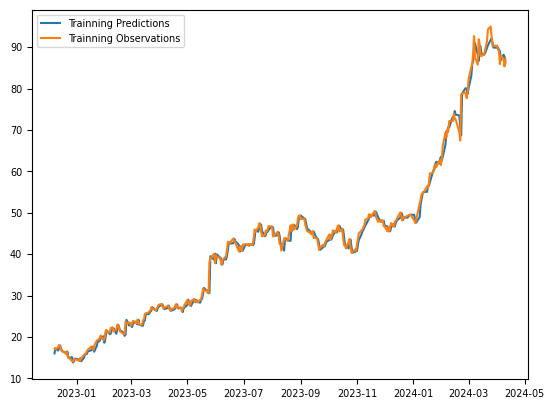

In [27]:
# -> Visualize the Trainning Performance

# Get the Trainning Predictions
train_preds = model.predict(X_train).flatten()

# Plot the Trainning Performance Data
plot_model_performance(dates_train, train_preds, y_train, ['Trainning Predictions', 'Trainning Observations']);

2/2 [==============================] - 0s 4ms/step


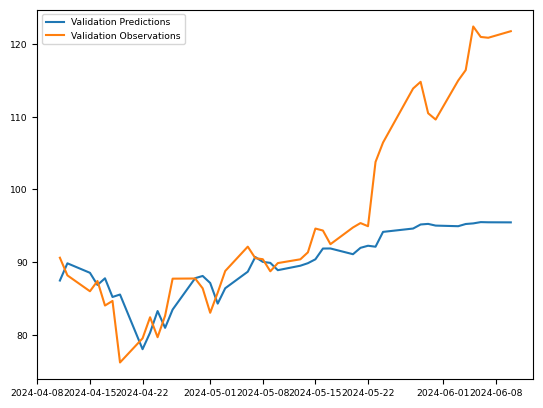

In [28]:
# -> Visualize the Validation Performance

# Get the Validation Predictions
validation_preds = model.predict(X_validation).flatten()

# Plot the Validation Performance Data
plot_model_performance(dates_validation, validation_preds, y_validation, ['Validation Predictions', 'Validation Observations']);

2/2 [==============================] - 0s 6ms/step


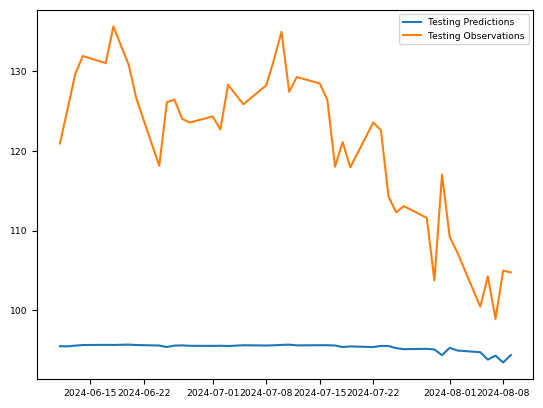

In [29]:
# -> Visualize Test Performance

# Get the Test Predictions
test_preds = model.predict(X_test).flatten()

# Plot the Test Performance Data
plot_model_performance(dates_test, test_preds, y_test, ['Testing Predictions', 'Testing Observations']);

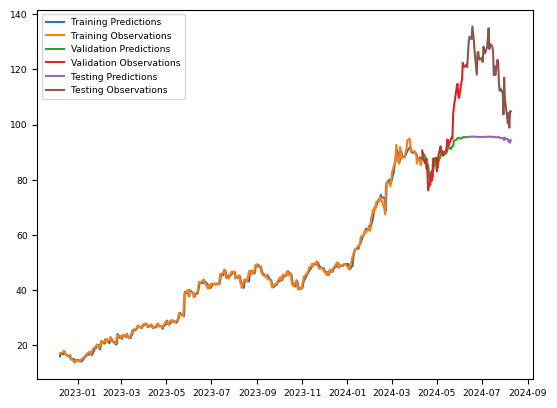

In [30]:
# -> Visualize the Model's performance throughout the all process

# Initialize some python lists with the data
dates_list = [dates_train, dates_validation, dates_test]
preds_list = [train_preds, validation_preds, test_preds]
y_list = [y_train, y_validation, y_test]
legend = ['Training Predictions',
          'Training Observations',
          'Validation Predictions',
          'Validation Observations',
          'Testing Predictions',
          'Testing Observations']

# Plot the Data
plot_model_overall_performance(dates_list, preds_list, y_list, legend);

# Save the final plot
if config['save_plot']:
    plt.savefig(f"./Assets/{config['stock']}_Stock_Price_Forecasting.png", bbox_inches='tight')